In [1]:
using ReinforcementLearningAnIntroduction

┌ Info: Precompiling ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1260
┌ Info: Skipping precompilation since __precompile__(false). Importing ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936].
└ @ Base loading.jl:1033
┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/tj/.julia/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


In [2]:
using Plots, StatsBase

In [3]:
mutable struct CountOfLeft <: AbstractHook
    counts::Vector{Int}
    count::Int
    CountOfLeft() = new([],0)
end

function (f::CountOfLeft)(::PreActStage, agent, env, obs, action)
    if get_state(obs) == 1 && action == MaximizationBias.LEFT
        f.count += 1
    end
end

function (f::CountOfLeft)(::PostEpisodeStage, agent, env, obs)
    push!(f.counts, f.count)
    f.count = 0
end


In [4]:
env = MaximizationBiasEnv()
ns, na = length(get_observation_space(env)), length(get_action_space(env))

(3, 10)

In [5]:
init_double_Q_agent() = Agent(
    policy=QBasedPolicy(
        learner=DoubleLearner(
            L1=TDLearner(
                approximator=TabularApproximator(n_state=ns, n_action=na),
                optimizer=Descent(0.1),
                method=:SARS
                ),
            L2=TDLearner(
                approximator=TabularApproximator(n_state=ns, n_action=na),
                optimizer=Descent(0.1),
                method=:SARS
                )
            ),
        explorer=EpsilonGreedyExplorer(0.1)
        ),
    trajectory=EpisodicCompactSARTSATrajectory()
)

init_Q_agent() = Agent(
    policy=QBasedPolicy(
        learner=TDLearner(
            approximator=TabularApproximator(n_state=ns, n_action=na),
            optimizer=Descent(0.1),
            method=:SARS
            ),
        explorer=EpsilonGreedyExplorer(0.1)
        ),
    trajectory=EpisodicCompactSARTSATrajectory()
)

init_Q_agent (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


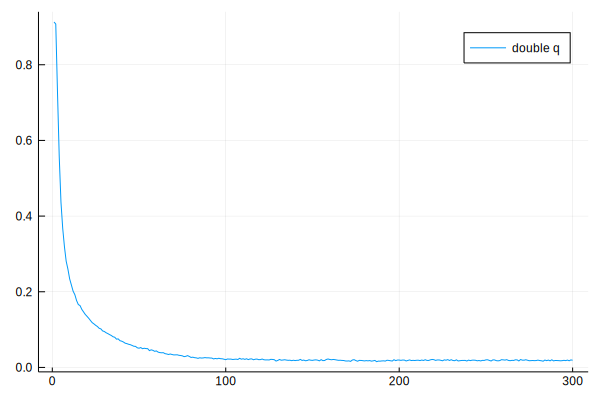

In [6]:
stats = []
for _ in 1:10000
    hook = CountOfLeft()
    run(init_double_Q_agent(), env, StopAfterEpisode(300),hook)
    push!(stats, hook.counts)
end

plot(mean(stats), legend=:topright, label="double q")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


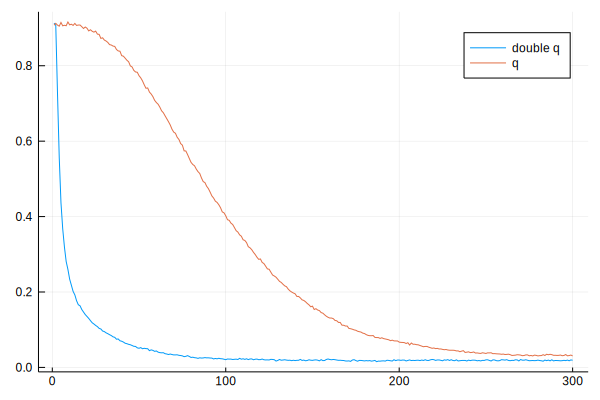

In [7]:
stats = []
for _ in 1:10000
    hook = CountOfLeft()
    run(init_Q_agent(), env, StopAfterEpisode(300),hook)
    push!(stats, hook.counts)
end
plot!(mean(stats), legend=:topright, label="q")

# TODO

We need to add a legal action here to restrict that the actions of the first step can only be 1(left) or 2(right). So that the figure will look exactly like the one on the book.